## Análise de Séries Temporais sobre a COVID 19 no Brasil

#### Importar Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import datetime as datetime
import plotly.express as px
import plotly.graph_objects as go
import re
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt 
from pmdarima.arima import auto_arima
from prophet import Prophet

c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Importar Base de Dados

In [2]:
dados = pd.read_csv(r"./database.csv", parse_dates=["ObservationDate", "Last Update"])
dados.head(10)

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,2020-01-22,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,2020-01-22,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,2020-01-22,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,2020-01-22,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,2020-01-22,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
5,6,2020-01-22,Guangdong,Mainland China,1/22/2020 17:00,26.0,0.0,0.0
6,7,2020-01-22,Guangxi,Mainland China,1/22/2020 17:00,2.0,0.0,0.0
7,8,2020-01-22,Guizhou,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
8,9,2020-01-22,Hainan,Mainland China,1/22/2020 17:00,4.0,0.0,0.0
9,10,2020-01-22,Hebei,Mainland China,1/22/2020 17:00,1.0,0.0,0.0


#### Tratamento dos Dados


In [3]:
# Analisando os Tipos de Dados das Colunas
dados.dtypes

SNo                         int64
ObservationDate    datetime64[ns]
Province/State             object
Country/Region             object
Last Update                object
Confirmed                 float64
Deaths                    float64
Recovered                 float64
dtype: object

In [4]:
# Corrigindo o tipo de dados da coluna "Last Update"
dados['Last Update'] = pd.to_datetime(dados['Last Update'],format='mixed')
dados.dtypes

SNo                         int64
ObservationDate    datetime64[ns]
Province/State             object
Country/Region             object
Last Update        datetime64[ns]
Confirmed                 float64
Deaths                    float64
Recovered                 float64
dtype: object

In [5]:
# Corrigindo os nomes das colunas 
def corrige_colunas(col_name):
    return re.sub(r"[/| ]", "", col_name).lower()

dados.columns = [corrige_colunas(col) for col in dados.columns]

dados.head(10)

,sno,observationdate,provincestate,countryregion,lastupdate,confirmed,deaths,recovered
0,1,2020-01-22,Anhui,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
1,2,2020-01-22,Beijing,Mainland China,2020-01-22 17:00:00,14.0,0.0,0.0
2,3,2020-01-22,Chongqing,Mainland China,2020-01-22 17:00:00,6.0,0.0,0.0
3,4,2020-01-22,Fujian,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
4,5,2020-01-22,Gansu,Mainland China,2020-01-22 17:00:00,0.0,0.0,0.0
5,6,2020-01-22,Guangdong,Mainland China,2020-01-22 17:00:00,26.0,0.0,0.0
6,7,2020-01-22,Guangxi,Mainland China,2020-01-22 17:00:00,2.0,0.0,0.0
7,8,2020-01-22,Guizhou,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
8,9,2020-01-22,Hainan,Mainland China,2020-01-22 17:00:00,4.0,0.0,0.0
9,10,2020-01-22,Hebei,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0


#### Brasil

In [6]:
# Trabalhando somente com dados do Brasil
brasil = dados.loc[(dados.countryregion == 'Brazil') & (dados.confirmed >0)]
brasil = brasil.set_index('sno')
brasil.index.name = None
brasil.columns.name = 'sno'
brasil.head(10)

sno,observationdate,provincestate,countryregion,lastupdate,confirmed,deaths,recovered
2456,2020-02-26,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2560,2020-02-27,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2669,2020-02-28,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2777,2020-02-29,NaN,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0
2904,2020-03-01,NaN,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0
3033,2020-03-02,NaN,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0
3174,2020-03-03,NaN,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0
3323,2020-03-04,NaN,Brazil,2020-03-04 20:33:02,4.0,0.0,0.0
3487,2020-03-05,NaN,Brazil,2020-03-04 20:33:02,4.0,0.0,0.0
3648,2020-03-06,NaN,Brazil,2020-03-06 20:33:03,13.0,0.0,0.0


In [7]:
# Verificando valores nulos e colunas desnecessárias
brasil.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84 entries, 2456 to 26359
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   observationdate  84 non-null     datetime64[ns]
 1   provincestate    0 non-null      object        
 2   countryregion    84 non-null     object        
 3   lastupdate       84 non-null     datetime64[ns]
 4   confirmed        84 non-null     float64       
 5   deaths           84 non-null     float64       
 6   recovered        84 non-null     float64       
dtypes: datetime64[ns](2), float64(3), object(2)
memory usage: 5.2+ KB


###### Não há dados a nível de Estado no país, somente a nível Nacional

In [8]:
# Excluido colunas desnessárias
brasil = brasil.drop(['provincestate','recovered'],axis=1)
brasil.head(10)

sno,observationdate,countryregion,lastupdate,confirmed,deaths
2456,2020-02-26,Brazil,2020-02-26 23:53:02,1.0,0.0
2560,2020-02-27,Brazil,2020-02-26 23:53:02,1.0,0.0
2669,2020-02-28,Brazil,2020-02-26 23:53:02,1.0,0.0
2777,2020-02-29,Brazil,2020-02-29 21:03:05,2.0,0.0
2904,2020-03-01,Brazil,2020-02-29 21:03:05,2.0,0.0
3033,2020-03-02,Brazil,2020-02-29 21:03:05,2.0,0.0
3174,2020-03-03,Brazil,2020-02-29 21:03:05,2.0,0.0
3323,2020-03-04,Brazil,2020-03-04 20:33:02,4.0,0.0
3487,2020-03-05,Brazil,2020-03-04 20:33:02,4.0,0.0
3648,2020-03-06,Brazil,2020-03-06 20:33:03,13.0,0.0


### Análise Exploratoria


In [9]:
# Conderando que os dados são acumulados iremos verificar o número de casos e mortes até o fim do período
n_confirmados = brasil.confirmed.max()
n_mortes = brasil.deaths.max()
ultimo_dia= brasil.observationdate.max().strftime("%d/%m/%Y")

print(f"Ao final do período analisado, em {ultimo_dia}, foram constatados {n_confirmados:,.0f} de casos confirmados e {n_mortes:,.0f} de mortes por COVID 19")

Ao final do período analisado, em 19/05/2020, foram constatados 271,885 de casos confirmados e 17,983 de mortes por COVID 19


#### Visualização: Casos Confirmados

In [10]:
 # Visualizando o número de casos confirmados 
 fig = px.line(brasil, 'observationdate', 'confirmed', 
    width= 920,
    labels={'observationdate':'Período', 'confirmed': 'Nº Casos Confirmados'},
    title= 'Casos Confirmados no Brasil'
)

fig.update_layout(template = 'plotly_dark')
fig.show()


### Número de Mortes

In [11]:
# Visualizando o número de mortes
fig = go.Figure()

fig.add_trace(
    go.Scatter( x=brasil.observationdate, y=brasil.deaths,  
    name='Número de Mortes', 
    mode='lines+markers',
    line=dict(color='red')
    )
)
fig.update_layout(title='Mortes por COVID 19 no Brasil', 
    xaxis_title='Período', 
    yaxis_title='Número de Mortes', 
    template='plotly_dark',
    width=920)
fig.show()

###  Novos Casos de COVID por Dia

In [12]:
# Vamos implementar uma função para fazer a contagem de novos cados de COVID 19
brasil['novoscasos'] = list(map(
    lambda x: 0 if (x==0) else brasil['confirmed'].iloc[x] - brasil['confirmed'].iloc[x-1],
    np.arange(brasil.shape[0] )
))

brasil.head(10)

sno,observationdate,countryregion,lastupdate,confirmed,deaths,novoscasos
2456,2020-02-26,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2560,2020-02-27,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2669,2020-02-28,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2777,2020-02-29,Brazil,2020-02-29 21:03:05,2.0,0.0,1.0
2904,2020-03-01,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0
3033,2020-03-02,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0
3174,2020-03-03,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0
3323,2020-03-04,Brazil,2020-03-04 20:33:02,4.0,0.0,2.0
3487,2020-03-05,Brazil,2020-03-04 20:33:02,4.0,0.0,0.0
3648,2020-03-06,Brazil,2020-03-06 20:33:03,13.0,0.0,9.0


In [13]:
# Visualizando os Novos Casos
fig = px.line(brasil, 'observationdate', 'novoscasos', 
    title='Novos Casos por Dia',
    width=920,
    labels={'observationdate': 'Período', 'novoscasos': 'Novos Casos'}
    )
fig.update_layout(template='plotly_dark')
fig.show()

### Taxa de Crescimento

taxa_crescimento = (presente/passado)**(1/n)-1

In [14]:
# Vamos calcular a taxa de crescimento do COVID 19 desde o primeiro dia
def taxa_crescimento(data, variable, data_inicio=None, data_fim=None):
    """
    Calcula a taxa de crescimento percentual de uma variável ao longo de um período de tempo.

    Parâmetros:
    - data (DataFrame): O conjunto de dados contendo a variável e a data de observação.
    - variable (str): O nome da variável para a qual a taxa de crescimento será calculada.
    - data_inicio (str ou None): A data de início do período. Se for None, usa a primeira data disponível no dataset.
    - data_fim (str ou None): A data de término do período. Se for None, usa a última data disponível no dataset.

    Retorna:
    - taxa (float): A taxa de crescimento percentual da variável ao longo do período especificado.
    """
    
    # Se a data_inicio for None, define como a primeira data disponível no dataset
    if data_inicio == None:
        data_inicio = data.observationdate.loc[data[variable] > 0].min()
    else:
        data_inicio = pd.to_datetime(data_inicio)
    
    # Se a data_fim for None, define como a última data disponível no dataset
    if data_fim == None:
        data_fim = data.observationdate.iloc[-1]
    else:
        data_fim = pd.to_datetime(data_fim)

    # Define os valores de presente e passado
    passado = data.loc[data.observationdate == data_inicio, variable].values[0]
    presente = data.loc[data.observationdate == data_fim, variable].values[0]

    # Define o número de pontos no tempo que iremos avaliar
    n = (data_fim - data_inicio).days

    # Calcular a taxa
    taxa = (presente/passado)**(1/n) - 1

    return taxa

In [15]:
# Taxa de Crescimento médio do COVID no Brasil em todo o Período
cresc_medio = taxa_crescimento(brasil,'confirmed')
print(f'O crescimento médio do COVID 19 no Brasil no período avaliado foi de {cresc_medio:.2%}.')

O crescimento médio do COVID 19 no Brasil no período avaliado foi de 16.27%.


#### Crescimento Diário

In [16]:
# Vamos observar o comportamento da taxa de crescimento diária
def taxa_crescimento_diária(data, variable, data_inicio=None):
    if data_inicio == None:
        data_inicio = data.observationdate.loc[data[variable] > 0].min()
    else:
        data_inicio = pd.to_datetime(data_inicio)

    data_fim = data.observationdate.max()

    n = (data_fim - data_inicio).days

    taxas = list(map(
        lambda x: (data[variable].iloc[x] - data[variable].iloc[x-1]) / data[variable].iloc[x-1],
        range(1, n+1)    
    ))
    return np.array(taxas)

In [17]:
# Taxa de Crescimento médio diário do COVID no Brasil no Período Avaliado
taxa_dia = taxa_crescimento_diária(brasil, 'confirmed')
taxa_media_diaria = taxa_dia.mean()
print(taxa_dia*100)
print(100*'-')
print(f'O crescimento médio diário do COVID 19 no Brasil foi de {taxa_media_diaria:.2%} durante o período avaliado.')

[  0.           0.         100.           0.           0.
   0.         100.           0.         225.           0.
  53.84615385  25.          24.          22.58064516  36.84210526
 190.38461538   0.           7.28476821  23.45679012  60.5
  15.88785047  66.93548387  27.69726248  28.75157629  51.4201763
  24.45019405  16.78794179  13.66266133  16.87548943  14.47236181
  14.25226807   9.01639344   7.58928571  24.8525879   19.57320273
  17.67115272  12.58080557  14.39929329   7.43243243   9.26325247
  15.40169394  15.22017956  11.88620903   8.54521335   5.54537122
   7.06807546   5.57858688   7.81903542  12.10513815   7.4329096
  10.70501233   8.83557983   5.44492335   5.4043566    5.73350023
   6.21648599   9.35157462   8.00823407   9.77184834   6.36504619
   6.88748019   8.58316283   8.80726429   9.41456987   5.75200431
   5.31224919   4.86714727   6.67216624   6.29257964   9.66263912
   7.23633807   8.19087742   6.24055441   4.25346499   4.23788714
   5.08272698   6.69027125   6.8519

In [18]:
primeiro_dia = brasil.observationdate.loc[brasil.confirmed > 0].min()
primeiro_dia

Timestamp('2020-02-26 00:00:00')

In [19]:
fig = px.line(x= pd.date_range(primeiro_dia, brasil.observationdate.max())[1:], 
    y= taxa_dia*100,
    title='Taxa diária de casos confirmados no Brasil',
    width=920,
    labels={'y': 'Taxa de Crescimento', 'x': 'Período'}
    )
fig.update_layout(template='plotly_dark')
fig.show()

### Predições

In [106]:
# Vamos construir um modelo de séries temporais para prever os novos casos.
novoscasos = brasil.novoscasos
novoscasos.index = brasil.observationdate
print(novoscasos)

# Decomposição da séries

resultado = seasonal_decompose(novoscasos) 


observationdate
2020-02-26        0.0
2020-02-27        0.0
2020-02-28        0.0
2020-02-29        1.0
2020-03-01        0.0
               ...   
2020-05-15    17126.0
2020-05-16    13220.0
2020-05-17     7569.0
2020-05-18    14288.0
2020-05-19    16517.0
Name: novoscasos, Length: 84, dtype: float64


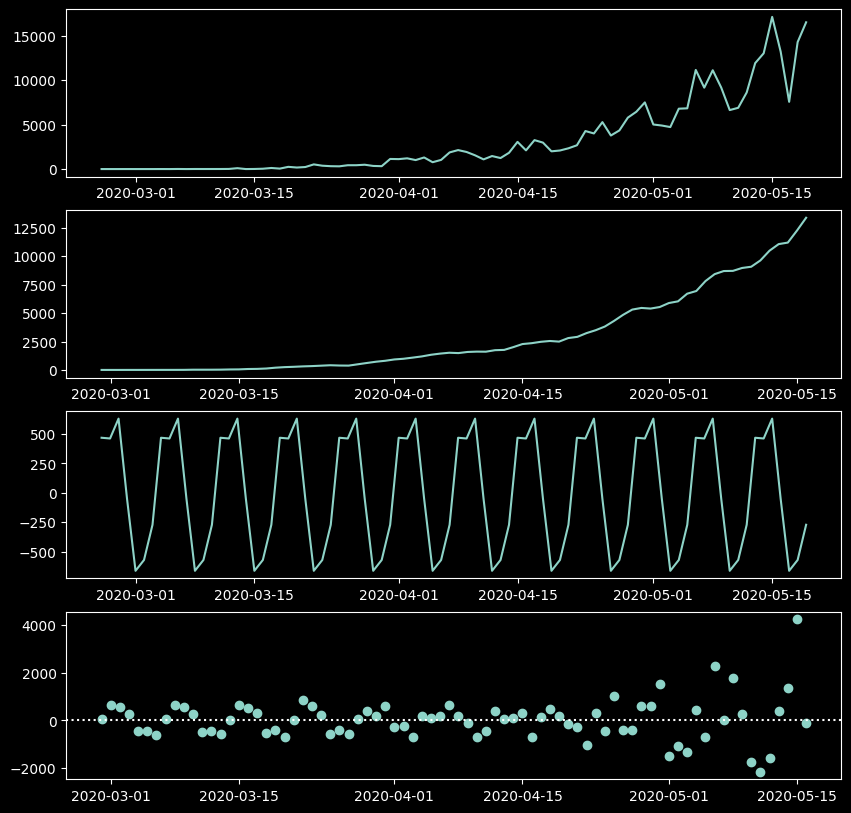

In [107]:
# Visualizando o modelo
plt.style.use('dark_background')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 10))
ax1.plot(resultado.observed) # Observados
ax2.plot(resultado.trend) # Tendência
ax3.plot(resultado.seasonal) # Sazonalidade
ax4.scatter(novoscasos.index, resultado.resid) # Ruido
ax4.axhline(0,linestyle= 'dotted', c='white')
plt.show()

In [109]:
# Vamos construir um modelo de séries temporais de casos confirmados.
confirmados = brasil.confirmed
confirmados.index = brasil.observationdate
print(confirmados)

# Decomposição da séries

resultado2 = seasonal_decompose(confirmados)

observationdate
2020-02-26         1.0
2020-02-27         1.0
2020-02-28         1.0
2020-02-29         2.0
2020-03-01         2.0
                ...   
2020-05-15    220291.0
2020-05-16    233511.0
2020-05-17    241080.0
2020-05-18    255368.0
2020-05-19    271885.0
Name: confirmed, Length: 84, dtype: float64


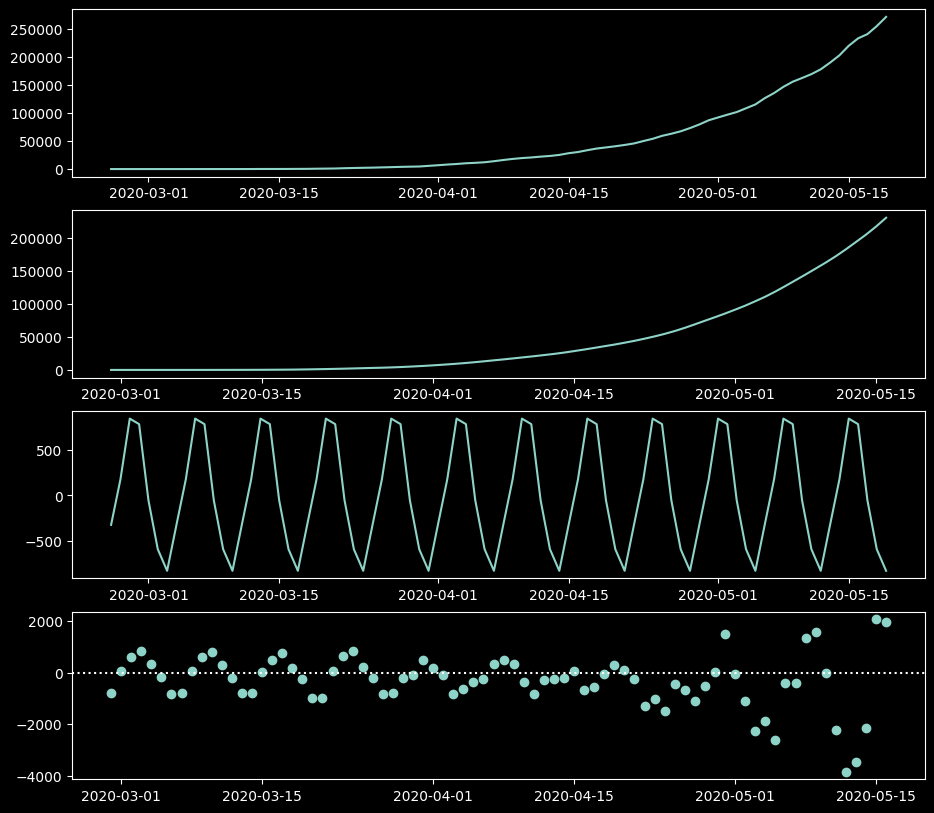

In [110]:
# Visualizando o modelo
plt.style.use('dark_background')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(11,10))

ax1.plot(resultado2.observed) # observados
ax2.plot(resultado2.trend) # Tendência
ax3.plot(resultado2.seasonal) # Sazonalidade
ax4.scatter(confirmados.index, resultado2.resid) # Ruido
ax4.axhline(0, linestyle= 'dotted', c='white')
plt.show()

### Metódo ARIMA

In [111]:
# Criando modelo
modelo = auto_arima(confirmados)

In [112]:
# Visualizando os dados de previsão do modelo
fig = go.Figure(go.Scatter(
    x=confirmados.index,
    y=confirmados,
    name='Observed'
))

fig.add_trace(go.Scatter(
    x=confirmados.index,
    y=modelo.predict_in_sample(),
    name='Predicted'
))

fig.add_trace(go.Scatter(
    x=pd.date_range('2020-05-20', '2020-06-05'),
    y=modelo.predict(15),
    name='Forecast'
))

fig.update_layout(
    template='plotly_dark',
    width=1080,
    title='Previsão de casos Confirmados para os Próximos 15 dias',
    yaxis_title='Casos Confirmados',
    xaxis_title='Período'
)

fig.show()



In [113]:
real = 584562
previsao = float(modelo.predict(15).max())

print(f'A previsão de casos confirmados para os próximos 15 dias é {previsao:,.0f} casos de COVID 19, o dado real mostrou-nos que alcançamos {real} casos de COVID 19')

A previsão de casos confirmados para os próximos 15 dias é 568,125 casos de COVID 19, o dado real mostrou-nos que alcançamos 584562 casos de COVID 19


In [98]:
print(f'Acurácia de {(previsao - real) / real + 1:.2%} ')

Acurácia de 97.19% 


### Metódo Forecasting com Facebook Prophet

In [85]:
# Preparando os dados
train = confirmados.reset_index()[:-5]
test = confirmados.reset_index()[-5:]

# Renomeado as colunas
train.rename(columns={'observationdate': 'ds', 'confirmed': 'y'}, inplace= True)
test.rename(columns={'observationdate': 'ds', 'confirmed': 'y'}, inplace=True)
test = test.set_index('ds')
test = test['y']


modelo = Prophet(growth='logistic')

pop = 211463256
train['cap'] = pop

# Treinar o modelo
modelo.fit(train)

# Construindo previsões
future_dates = modelo.make_future_dataframe(periods=200)
future_dates['cap'] = pop
forecast = modelo.predict(future_dates)

09:53:36 - cmdstanpy - INFO - Chain [1] start processing
09:53:52 - cmdstanpy - INFO - Chain [1] done processing


In [86]:
# Visualizado a previsão do modelo

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=forecast.ds,
    y=forecast.yhat,
    name='Predição'
))

fig.add_trace(go.Scatter(
    x=test.index,
    y=test,
    name='Teste - Observados'
))

fig.add_trace(go.Scatter(
    x=train.ds,
    y=train.y,
    name='Treino - Observados'
))

fig.update_layout(
    title='Predições de casos Confirmados no Brasil',
    template='plotly_dark',
    width=1080
)
fig.show()